<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/L2_UQ_structure_non_structurred_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncertainty models

In [7]:
import sys
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

## Parametric models
- gaussian univariate
- gaussian mixture model

In [8]:
# Example for a Gaussian model
class Gaussian:
  """A simple univariate model f(x) = N(mean,sigma)"""
  def __init__(self, mu, sigma):
    self.mu = mu
    self.sigma = sigma
    self.dist = norm(loc=self.mu, scale=self.sigma)

  def pdf(self, x):  # probability density function  for the gaussian family
    return (1 / (self.sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - self.mu) / self.sigma) ** 2)

  def cdf(self, x): # cumulative distribution function for the gaussian family
    return 0.5 * (1 + np.vectorize(math.erf)((x - self.mu) / (self.sigma * np.sqrt(2))))

  def icdf(self, alpha):
    # inverse of the cdf
    return self.dist.ppf(alpha)


  def sample(self, n_samples):
      # generate samples from the CDF
      # 1. sample alpha as Uniform[0,1]
      # w. then inverse CDF for alpha
      alpha_vals = np.random.uniform(0, 1, n_samples)
      return self.icdf(alpha_vals)



# Define a Gaussian Mixture Model (GMM)
class GaussianMixtureModel:
    """
    A simple Gaussian Mixture model
    see other packages, e.g., sklearn, for more complete implementations
    """

    def __init__(self, components, weights):
        self.components = components  # List of Gaussian components
        self.weights = weights  # List of weights for each component

    def pdf(self, x):
        result = np.zeros_like(x)
        for weight, component in zip(self.weights, self.components):
            result += weight * component.pdf(x)
        return result

    def cdf(self, x):
        result = np.zeros_like(x)
        for weight, component in zip(self.weights, self.components):
            result += weight * component.cdf(x)
        return result

    def icdf(self, alpha, tol=1e-6, max_iter=100):
        low, high = -1e6, 1e6  # Assume an appropriate range for ICDF
        result = []

        for a in np.atleast_1d(alpha):  # Allow alpha to be a scalar or array
            # Binary search for each alpha
            for _ in range(max_iter):
                mid = (low + high) / 2
                if np.abs(self.cdf(mid) - a) < tol:
                    result.append(mid)
                    break
                elif self.cdf(mid) < a:
                    low = mid
                else:
                    high = mid
            else:
                raise ValueError("Inverse CDF did not converge.")
        return np.array(result) if len(result) > 1 else result[0]

    def sample(self, n_samples):
        samples = []
        for _ in range(n_samples):
            # Choose a component based on the weights
            component = np.random.choice(self.components, p=self.weights)
            sample = component.sample(1)  # Sample 1 value from the chosen component
            samples.append(sample[0])
        return np.array(samples)


## A univariate multimodel GMM with 3 components


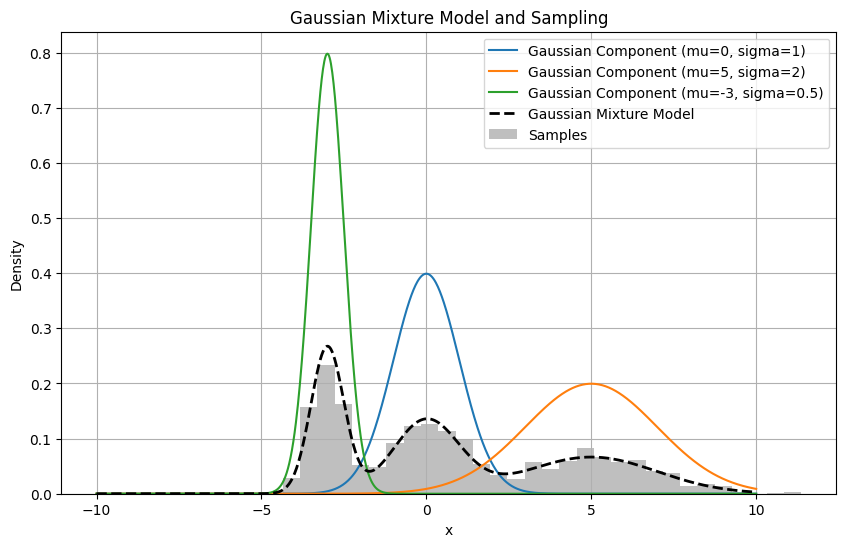

In [9]:
# 3 Gaussian Components
gaussian1 = Gaussian(mu=0, sigma=1)
gaussian2 = Gaussian(mu=5, sigma=2)
gaussian3 = Gaussian(mu=-3, sigma=0.5)

# weights for the mixture
weights = [1/3, 1/3, 1/3]  # Sum to 1

# define GMM
GMM3 = GaussianMixtureModel(components=[gaussian1, gaussian2, gaussian3], weights=weights)

# sample data from the GMM
n_samples = 1000
samples = GMM3.sample(n_samples)

#  plot example ...x values for plotting the PDF
x = np.linspace(-10, 10, 1000)
plt.figure(figsize=(10, 6))

for component, weight in zip(GMM3.components, GMM3.weights):
    plt.plot(x, component.pdf(x), label=f'Gaussian Component (mu={component.mu}, sigma={component.sigma})')

# Plot the GMM PDF
plt.plot(x, GMM3.pdf(x), label='Gaussian Mixture Model', linewidth=2, color='black', linestyle='--')

# Show samples
plt.hist(samples, bins=30, density=True, alpha=0.5, color='gray', label='Samples')

plt.title('Gaussian Mixture Model and Sampling')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

## Probabilistic (structured/non-structured) and Set-based models
- GMM bi-variate data examples
- Parametric (GMM) vs Non-Parametric (Kernel Density Estimator)
- Data enclosing sets

In [32]:
import numpy.random as random
import scipy.stats as stats
import seaborn as sns

from matplotlib.collections import LineCollection
from scipy.spatial import ConvexHull
from scipy.spatial import convex_hull_plot_2d

from sklearn.datasets import make_blobs, make_moons
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity

* Define Data Generation Mechanism
* Data encolsing ball and hull

In [33]:

def data_generation_mechanism(n_samples: int = 100,
                              n_dimensions: int = 1,
                              type='normal',
                              add_noise: bool = False,
                              nose_level: float = 0.5):
    """
    Generates a matrix of random data with specified number of samples and dimensions.

    Parameters:
    - n_samples (int): Number of samples (rows of the matrix).
    - n_dimensions (int): Number of dimensions (columns of the matrix).
    - type (str): The type of data distribution ('normal', 'blobs', 'two_moons').

    Returns:
    - np.ndarray: A matrix with shape (n_samples, n_dimensions), filled with random data.
    """
    # Default to 'normal' if no type is specified
    if type is None:
        type = 'normal'

    if type == 'normal':
        # For normal distribution, we use a multivariate normal distribution
        mean = [0] * n_dimensions  # Mean vector
        cov = np.eye(n_dimensions)  # Identity covariance matrix (no correlation)
        data_matrix = np.random.multivariate_normal(mean, cov, size=n_samples)

    elif type == 'blobs':
        # Generate data from blobs (clusters of points)
        data_matrix, _ = make_blobs(n_samples=n_samples, n_features=n_dimensions, random_state=42)

    elif type == 'two_moons':
        # Generate two moons dataset (non-linear)
        data_matrix, _ = make_moons(n_samples=n_samples, noise=0.1, random_state=42)

    else:
        raise ValueError(f"Unsupported data type: {type}")


    if add_noise:
        # Add Gaussian noise to the data
        noise = np.random.normal(0, nose_level, size=(n_samples, n_dimensions))
        data_matrix += noise

    return data_matrix


def plot_disk(center, radius, data_points=None,  ax=None, show=True):
    """
    Plot a 2D disk (circle) with a given center and radius, and optionally the data points.

    Parameters:
    - center (array-like): The center of the disk (x, y).
    - radius (float): The radius of the disk.
    - data_points (array-like, optional): Data points to plot on the same figure.
    """
    if ax is None:
        fig, ax = plt.subplots()

    # Plot the data points
    if data_points is not None:
        ax.scatter(data_points[:, 0], data_points[:, 1], color='blue', label='Data Points')

    # Create a circle representing the enclosing disk
    circle = plt.Circle(center, radius, color='red', fill=False, linestyle='--', linewidth=2, label='Enclosing Disk')

    ax.add_artist(circle)

    # Set the limits of the plot for better visibility
    ax.set_xlim(center[0] - radius - 1, center[0] + radius + 1)
    ax.set_ylim(center[1] - radius - 1, center[1] + radius + 1)

    # Set equal scaling and labels
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.grid(True)

    if show:
        ax.legend()
        ax.set_title("Minimum Enclosing Disk")
        plt.show()



def data_enclosing_ball(points, reject_percentage=0.0):
    """
    Given a set of points in n-dimensional space, computes a minimum volume encolsing ball
    """
    # For simplicity, we compute the convex hull and then calculate the smallest enclosing ball.
    points = np.array(points)
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]

    # Compute the centroid and maximum distance from the centroid to any point on the hull
    center = np.mean(hull_points, axis=0)
    radius = max(np.linalg.norm(center - point) for point in hull_points)

    if reject_percentage > 0 and reject_percentage < 100:
        n_samples = len(points)
        n_samples_2_keep = int((100 - reject_percentage)/100 * len(points))
        n_samples_discard = n_samples-n_samples_2_keep
        points_inner_hull = points.copy()

        while len(points_inner_hull) >= n_samples_2_keep:

            if len(hull.vertices) > n_samples_discard:
                points_inner_hull = np.delete(points_inner_hull, hull.vertices[:n_samples_discard], axis=0)
            else:
                points_inner_hull = np.delete(points_inner_hull, hull.vertices, axis=0)

            hull = ConvexHull(points_inner_hull)
            hull_points = points[hull.vertices]

        center = np.mean(points_inner_hull, axis=0)
        radius = max(np.linalg.norm(center - point) for point in hull_points)

    elif reject_percentage >= 100:
        print(reject_percentage, "percent of the points are rejected. No enclosing ball can be computed.")
        return None, None, None

    return center, radius, hull



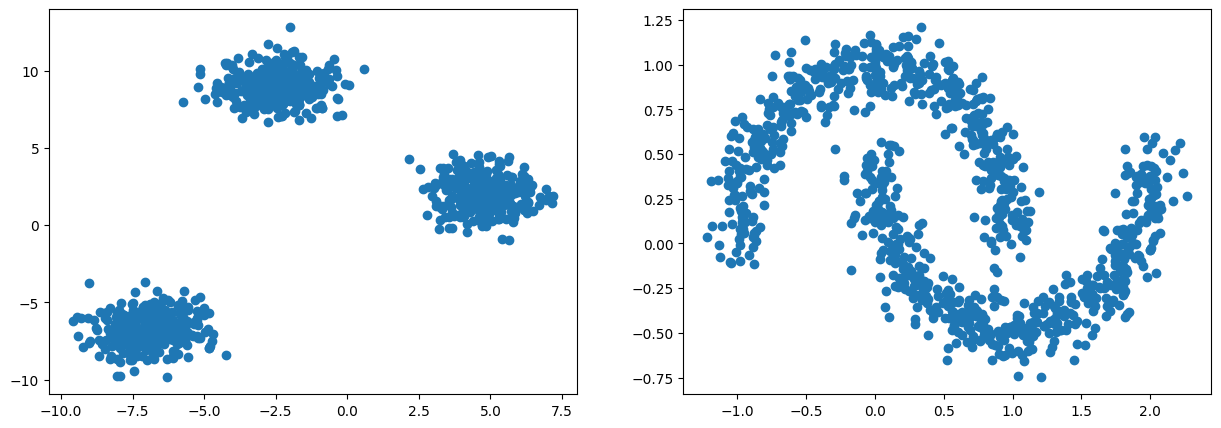

In [15]:
# Data Generation Mechanism:
n_samples = 1000  # Number of samples
n_dimensions = 2  # Number of dimensions
data_blobs = data_generation_mechanism(n_samples, n_dimensions, type='blobs')      # Generate data of type 'blobs'
data_moons = data_generation_mechanism(n_samples, n_dimensions, type='two_moons', add_noise=False)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(data_blobs[:, 0], data_blobs[:, 1], 'o', label='blobs')
ax[1].plot(data_moons[:, 0], data_moons[:, 1], 'o', label='two_moons')
plt.show()

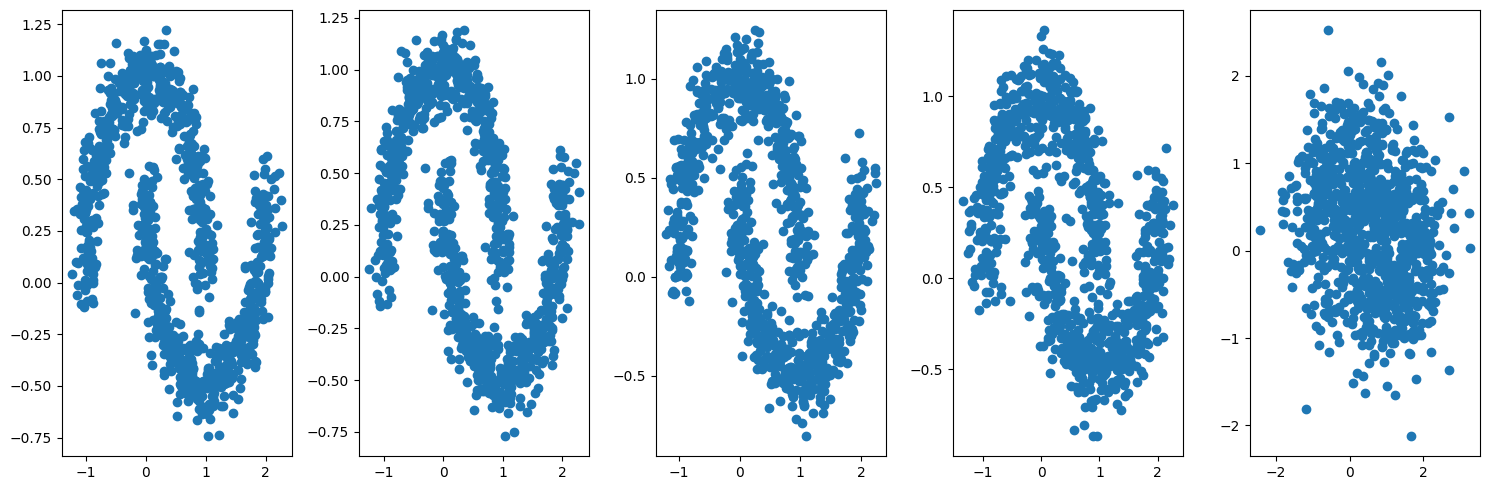

In [16]:
# Generating mechanism + additional noise
noise_levels = [0.01, 0.02, 0.05, 0.1, 0.5]
fig, axs = plt.subplots(1, len(noise_levels), figsize=(15, 5))
for noise_level, ax in zip(noise_levels, axs):
    data_moons_noise = data_generation_mechanism(n_samples, n_dimensions, type='two_moons', add_noise=True, nose_level=noise_level)
    ax.plot(data_moons_noise[:, 0], data_moons_noise[:, 1], 'o', label=f'two_moons (noise={noise_level})')
plt.tight_layout()
plt.show()

In [34]:
# Find data-enclosing set (convex hull, sphere) for the data
center, radius, hull = data_enclosing_ball(data_moons.tolist())

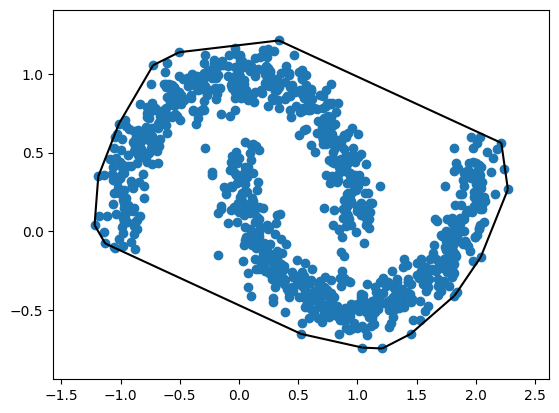

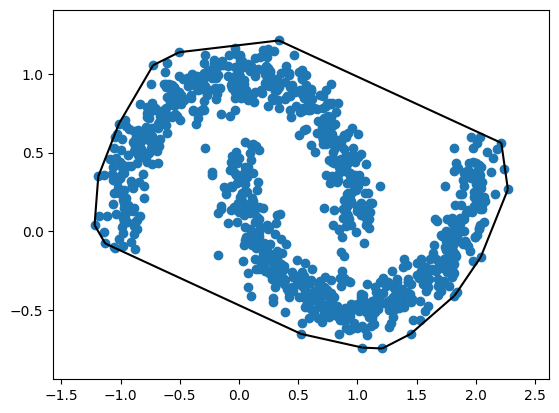

In [36]:
convex_hull_plot_2d(hull)

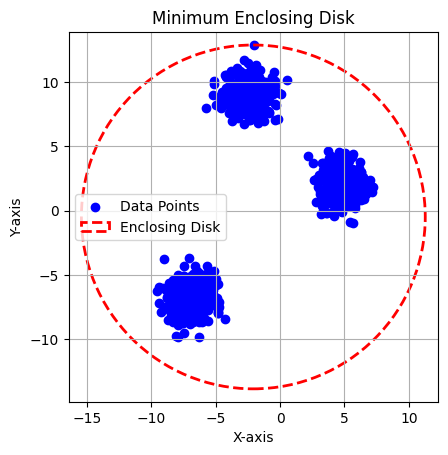

In [30]:
center, radius, hull = data_enclosing_ball(data_blobs.tolist())
plot_disk(center, radius, data_blobs)

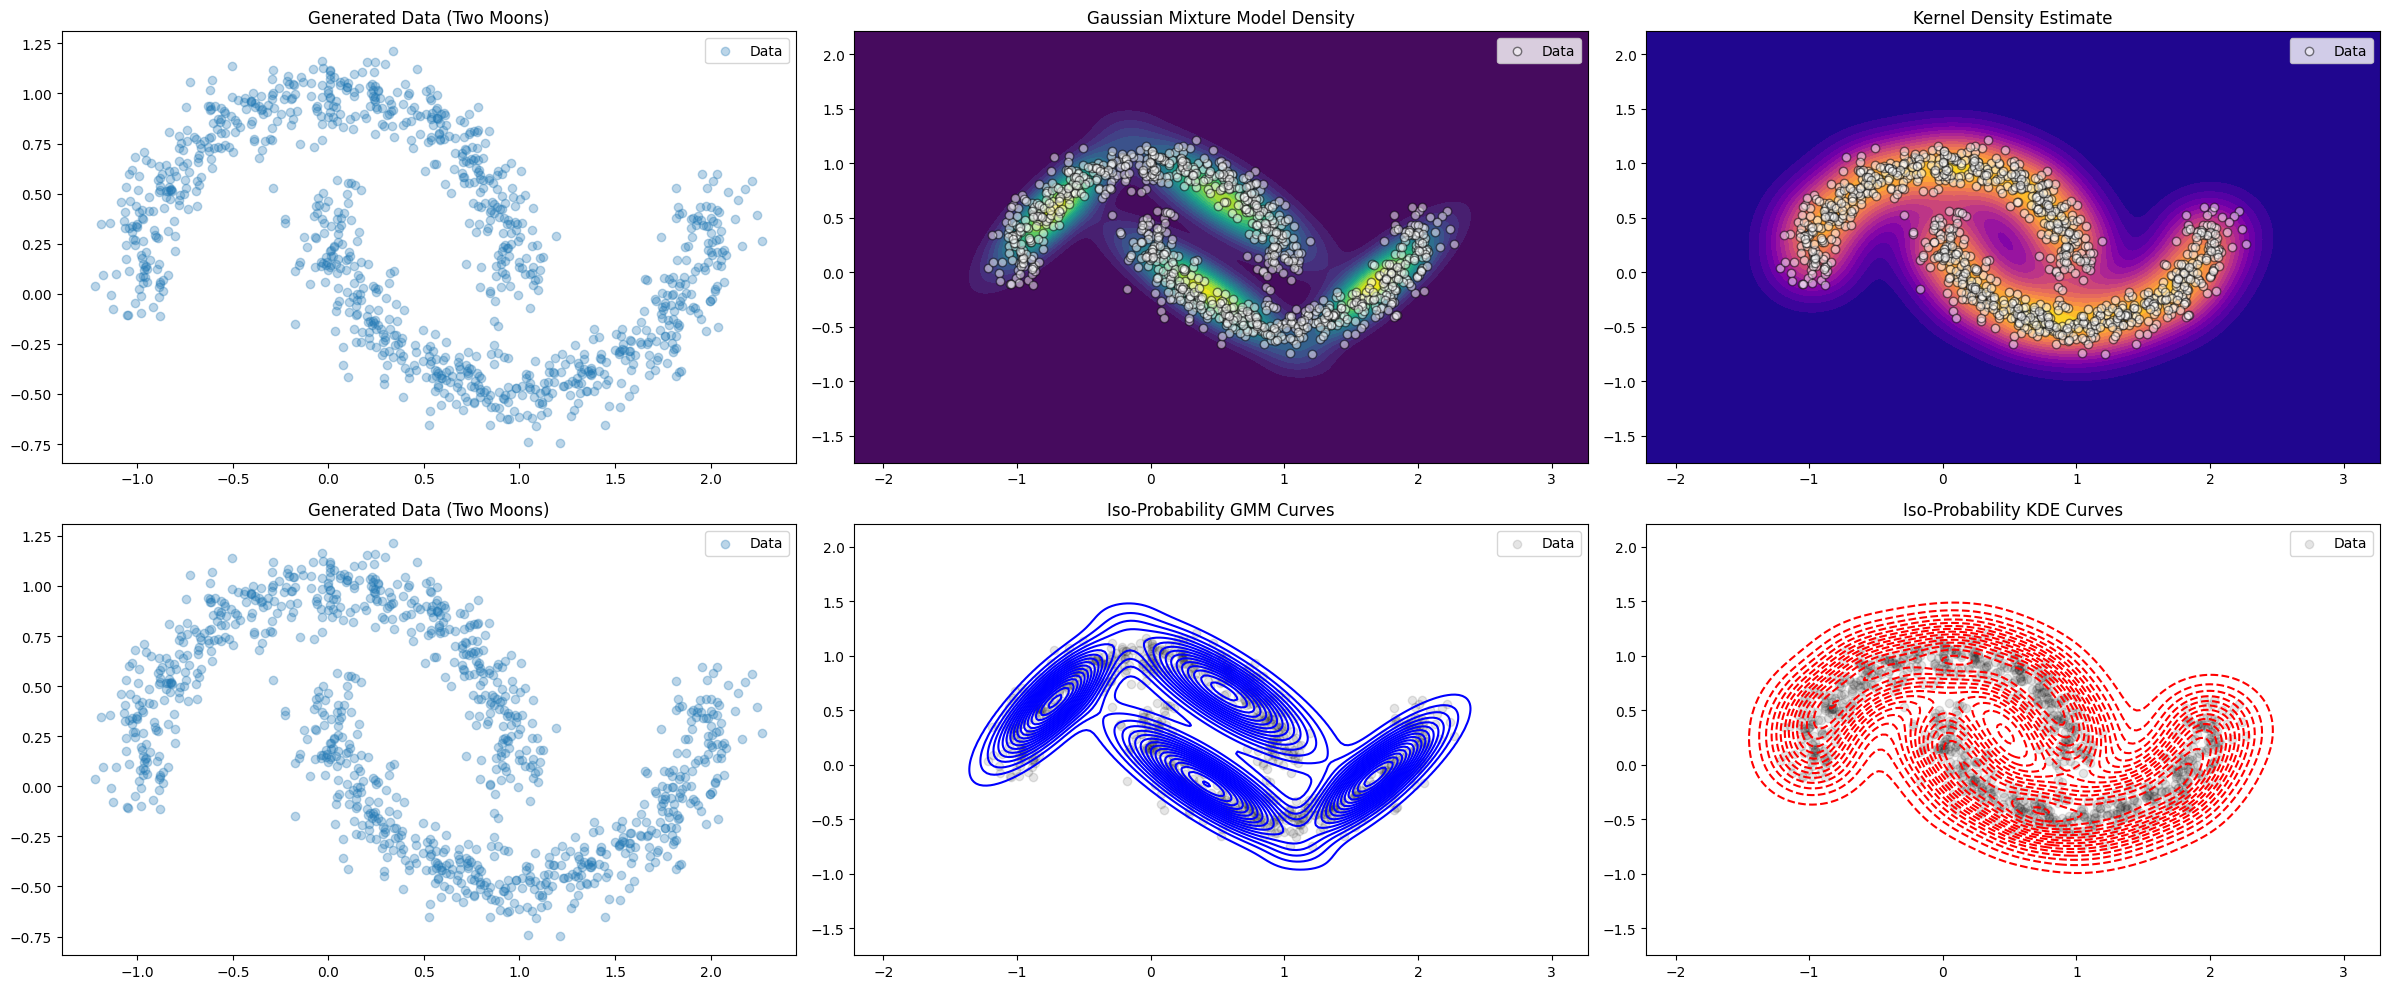

In [23]:
GMM = GaussianMixture(n_components=4, covariance_type='full', random_state=42)

def visualize_fitters(data, gmm, bandwidth=0.1, n_grid_points=200):
  # Fit a Gaussian Mixture Model

  # Fit a KDE model
  GMM.fit(data)
  kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
  kde.fit(data)

  # Create a mesh grid for density visualization
  x = np.linspace(min(data[:, 0])-1, max(data[:, 0])+1, n_grid_points)
  y = np.linspace(min(data[:, 1])-1, max(data[:, 1])+1, n_grid_points)
  X, Y = np.meshgrid(x, y)
  grid_points = np.column_stack([X.ravel(), Y.ravel()])

  # Evaluate densities
  gmm_density = np.exp(gmm.score_samples(grid_points)).reshape(X.shape)
  kde_density = np.exp(kde.score_samples(grid_points)).reshape(X.shape)

  # Visualize results
  fig, ax = plt.subplots(2, 3, figsize=(24, 10))

  # Raw data
  ax[0,0].scatter(data[:, 0], data[:, 1], alpha=0.3, label="Data")
  ax[0,0].set_title("Generated Data (Two Moons)")
  ax[0,0].legend()
  ax[1,0].scatter(data[:, 0], data[:, 1], alpha=0.3, label="Data")
  ax[1,0].set_title("Generated Data (Two Moons)")
  ax[1,0].legend()

  # GMM density
  ax[0,1].contourf(X, Y, gmm_density, levels=20, cmap='viridis')
  ax[0,1].scatter(data[:, 0], data[:, 1], alpha=0.5, color="white", edgecolor="k", label="Data")
  ax[0,1].set_title("Gaussian Mixture Model Density")
  ax[0,1].legend()

  # KDE density
  ax[0,2].contourf(X, Y, kde_density, levels=20, cmap='plasma')
  ax[0,2].scatter(data[:, 0], data[:, 1], alpha=0.5, color="white", edgecolor="k", label="Data")
  ax[0,2].set_title("Kernel Density Estimate")
  ax[0,2].legend()

  # Iso-probability density curves
  ax[1,1].contour(X, Y, gmm_density, levels=20, colors='blue', linestyles='solid')
  ax[1,2].contour(X, Y, kde_density, levels=20, colors='red', linestyles='dashed')
  ax[1,1].scatter(data[:, 0], data[:, 1], alpha=0.1, color="black", label="Data")
  ax[1,2].scatter(data[:, 0], data[:, 1], alpha=0.1, color="black", label="Data")
  ax[1,1].set_title("Iso-Probability GMM Curves")
  ax[1,2].set_title("Iso-Probability KDE Curves")
  ax[1,2].legend()
  ax[1,1].legend()

  plt.tight_layout()
  plt.show()



sualize_fitters(data=data_moons, gmm=GMM, bandwidth=0.2)

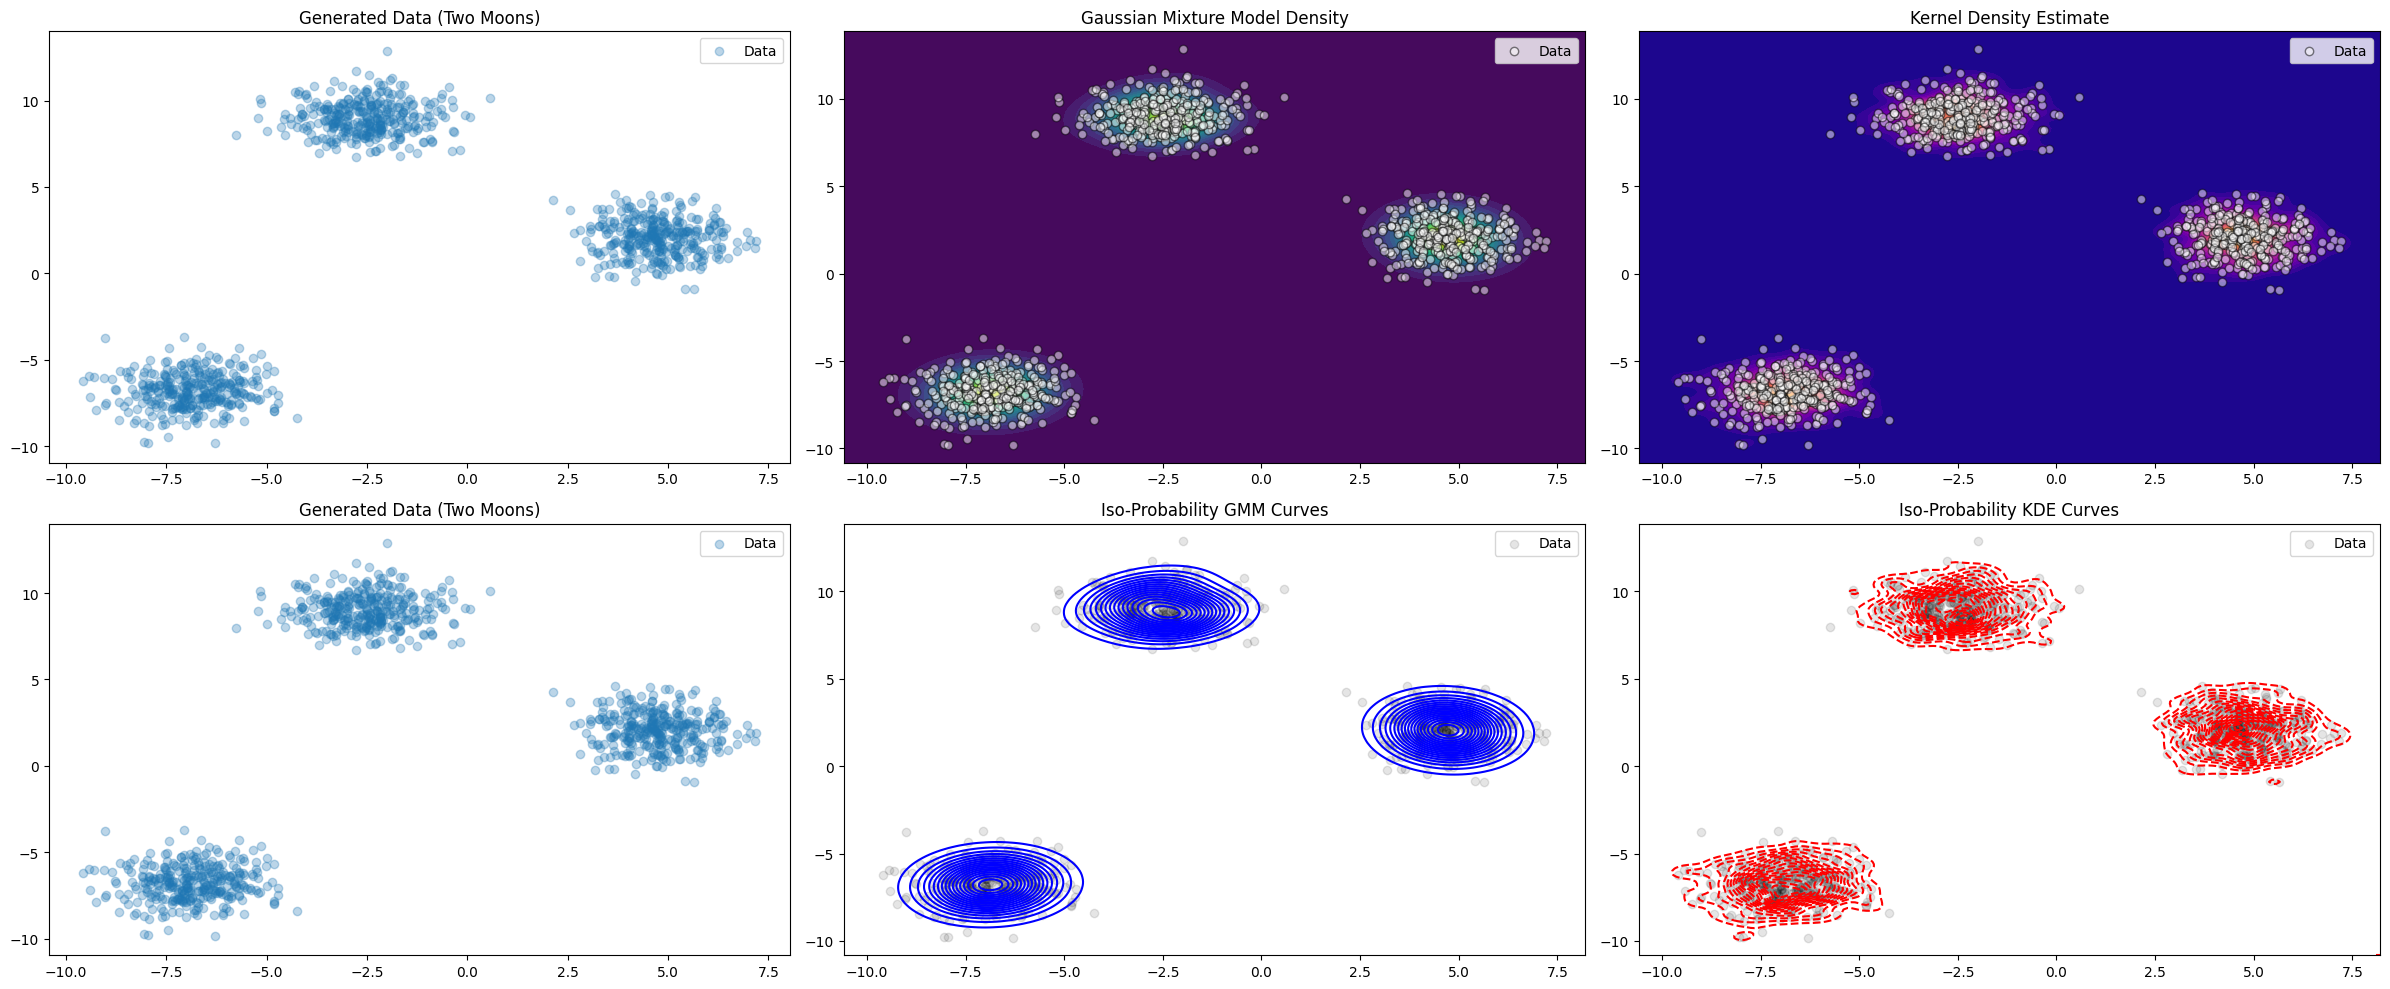

In [37]:
gmm_blobs= GaussianMixture(n_components=4, covariance_type='full', random_state=42)
gmm_blobs.fit(data_blobs)
visualize_fitters(data=data_blobs, gmm=gmm_blobs, bandwidth=0.3)

<ipython-input-3-0b1fe2142715>:21: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(X, Y, norm1, levels=[1], colors='b', linestyles='dashed', linewidths=2, label='Norm 1')
<ipython-input-3-0b1fe2142715>:22: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(X, Y, norm2, levels=[1], colors='g', linestyles='dotted', linewidths=2, label='Norm 2')
<ipython-input-3-0b1fe2142715>:23: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(X, Y, norminf, levels=[1], colors='r', linestyles='solid', linewidths=2, label='Infinity Norm')
<ipython-input-3-0b1fe2142715>:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


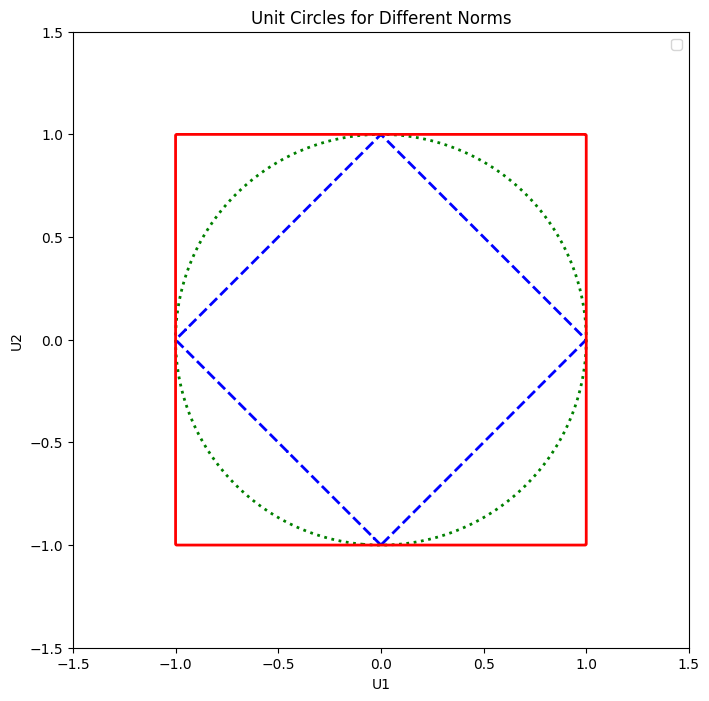

In [3]:
# prompt: plot infinity norm, norm 2 and norm 1 sets in a 2d plane (the infinity norm shold contain the others right if nomr(u,p)<=1)

import matplotlib.pyplot as plt
import numpy as np

# Create a grid of points in the 2D plane
x = np.linspace(-1.5, 1.5, 400)
y = np.linspace(-1.5, 1.5, 400)
X, Y = np.meshgrid(x, y)

# Calculate the norms for each point in the grid
norm1 = np.abs(X) + np.abs(Y)
norm2 = np.sqrt(X**2 + Y**2)
norminf = np.maximum(np.abs(X), np.abs(Y))


# Create the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the unit circles for each norm
ax.contour(X, Y, norm1, levels=[1], colors='b', linestyles='dashed', linewidths=2, label='Norm 1')
ax.contour(X, Y, norm2, levels=[1], colors='g', linestyles='dotted', linewidths=2, label='Norm 2')
ax.contour(X, Y, norminf, levels=[1], colors='r', linestyles='solid', linewidths=2, label='Infinity Norm')

# Add labels and legend
ax.set_xlabel('U1')
ax.set_ylabel('U2')
ax.set_title('Unit Circles for Different Norms')
ax.set_aspect('equal')
ax.legend()

# Show the plot
plt.grid
plt.show()


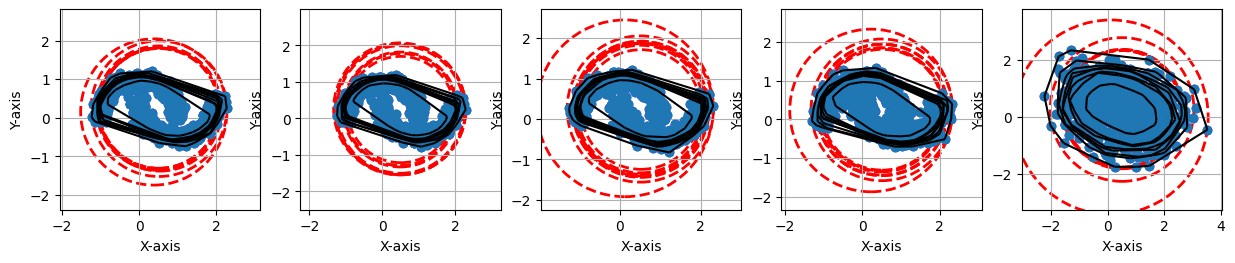

Center of data enclosing disk: [0.50453716 0.25673568]
Radius of data enclosing disk: 2.5341172349508114


In [24]:
# Epistemic sets with removed samples
reject_percentages = [0, 2, 4, 8, 10, 15, 20, 50]
fig, axs = plt.subplots(1, len(noise_levels), figsize=(15, 5))

for noise_level, ax in zip(noise_levels, axs):
    data_moons_noise = data_generation_mechanism(n_samples, n_dimensions,
                                                  type='two_moons',
                                                  add_noise=True,
                                                  nose_level=noise_level)

    for i_r, reject_percentage in enumerate(reject_percentages):
        center, radius, hull = data_enclosing_ball(data_moons_noise.tolist(), reject_percentage=reject_percentage)
        if i_r == 0:
            plot_disk(center, radius, data_moons_noise, ax=ax, show=False)
            convex_hull_plot_2d(hull, ax=ax)
        else:
            line_segments = [hull.points[simplex] for simplex in hull.simplices]
            ax.add_collection(LineCollection(line_segments,
                                              colors='k',
                                              linestyle='solid'))
            plot_disk(center, radius, None, ax=ax, show=False)
plt.show()



print("Center of data enclosing disk:", center)
print("Radius of data enclosing disk:", radius)